In [1]:
# Credit Scorecard example. Following: https://rpubs.com/chidungkt/442168
# Attempt to convert it into python language

import numpy as np
import pandas as pd
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# scorecard package version is made for an older version of pandas
# some warnings need to be suppressed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read csv
df = pd.read_csv('hmeq.csv')

In [3]:
# Print head
print(df.head())

   BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN  


In [4]:
# Replaced NA values by the mean
# Will only fill for number dtypes (int, float)
df = df.fillna(df.mean())

# Impute values for categorical variables
# A random weighted sample will be taken of the exisitng variables and applied
# for each missing value

# Reason - 252 Missing
df.REASON.value_counts() # DebtCon 3928, HomeImp 1780
df['ReasonFreq'] = df['REASON'].map(df['REASON'].value_counts())
df.REASON = np.where(
    df.REASON.isna(),
    df.REASON.sample(n=1, weights=df['ReasonFreq']),
    df.REASON
)

# Job - 279 Missing
df.JOB.value_counts() # DebtCon 3928, HomeImp 1780
df['JobFreq'] = df['JOB'].map(df['JOB'].value_counts())
df.JOB = np.where(
    df.JOB.isna(),
    df.JOB.sample(n=1, weights=df['JobFreq']),
    df.JOB
)

# Drop freq columns
df = df.drop(['ReasonFreq', 'JobFreq'], axis=1)

In [5]:
# Not currently done the variable selection.

In [6]:
# Variable selected by the example
cols = [
    'LOAN', 'VALUE', 'REASON', 'JOB', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
    'CLNO', 'DEBTINC'
]

X = df[cols]
y = df['BAD']
df_new = pd.concat([X, y], axis=1)

# split into train and test set
train, test = sc.split_df(df_new, 'BAD').values()

In [7]:
# Get woe bins
bins = sc.woebin(df_new, y='BAD')

[INFO] creating woe binning ...
Binning on 5960 rows and 11 columns in 00:00:17


In [8]:
# Convert values into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [9]:
# Get x and y train and test sets

y_train = train_woe.loc[:,'BAD']
X_train = train_woe.loc[:,train_woe.columns != 'BAD']
y_test = test_woe.loc[:,'BAD']
X_test = test_woe.loc[:,train_woe.columns != 'BAD']

In [10]:
# Fit logit model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
# Get probabilities
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

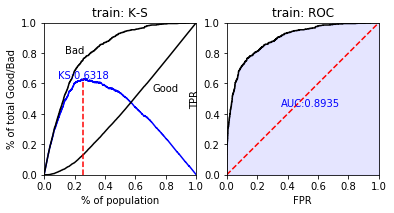

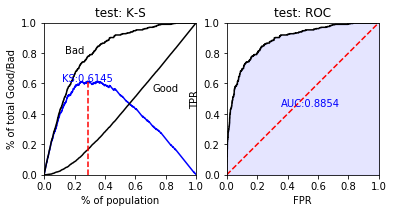

In [12]:
# Plot diagnositcs
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [13]:
card = sc.scorecard(bins, lr, X_train.columns)

In [14]:
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

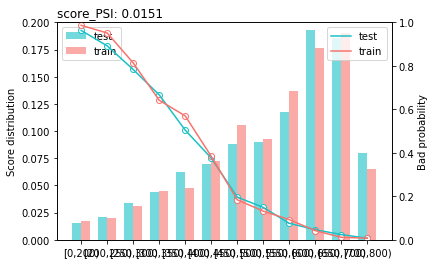

{'psi':   variable       PSI
 0    score  0.015136, 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [15]:
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)